In [5]:
from q_learning import QLearner, QLearningConfig, LearningTactic
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

W każdej wersji będę używał następującej dyskretyzacji - podziału na buckety (static binning). Na przykład tablica [0.35, 0.15, 0.15, 0.35] ozacza, że 35% najmniejszych wartości z przedziału [lower_bound, upper_bound] będzie należeć do bucketu 0, 15% kolejnych do bucketu 1, 15% kolejnych do bucketu 2 i 35% najwyższych wartości do bucketu 3.

In [2]:
upper_bounds=[4.8, 0.5, 0.418, math.radians(50)]
lower_bounds=[-4.8, -0.5, -0.418, -math.radians(50)]

discretization = [[0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25],
                  [0.35, 0.15, 0.15, 0.35],
                  [0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25],
                  [0.3, 0.15, 0.05, 0.05, 0.15, 0.3]]

# Eksperyment ze statycznymi parametrami - Q-learning i Sarsa
Dla każdego paramteru, chcę przetstować jak wygląda proces uczenia z małą i dużą wartością tego paramtru. Co daje 8 eksperymentów. Zdecydowałem, że dla zaproponowanej przeze mnie dyskretyzacji 16 000 epizodów powinno wystarczyć na wytrenowanie modelu

In [18]:
alphas = [0.2, 0.8]
epsilons = [0.3, 0.7]
discounts = [0.6, 0.99]

d:\anaconda3\envs\myenv\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


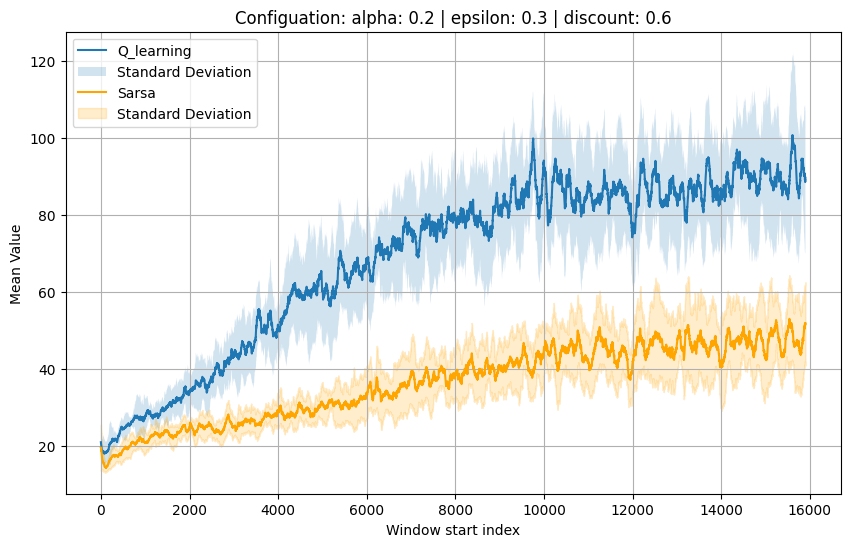

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


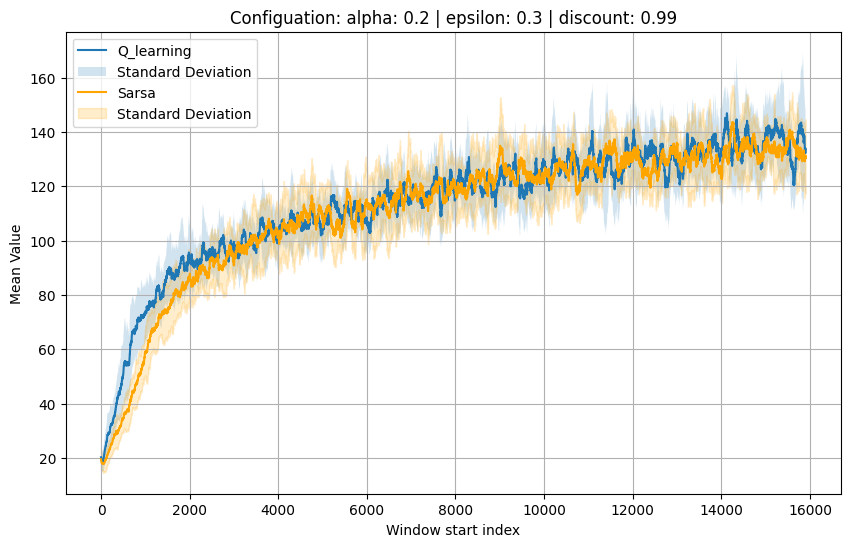

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


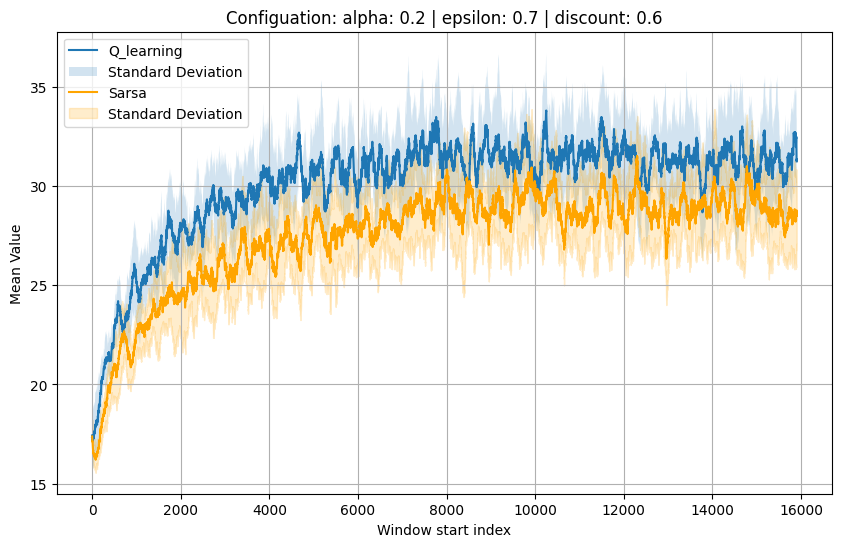

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


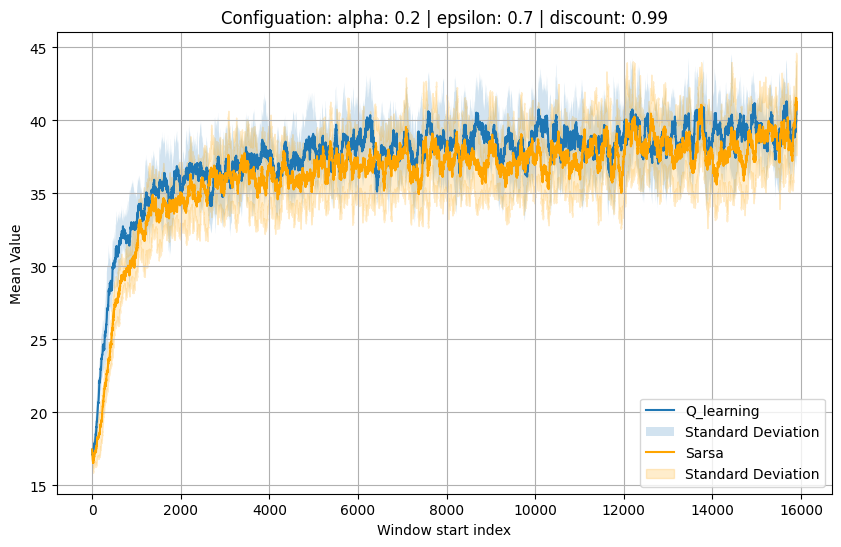

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


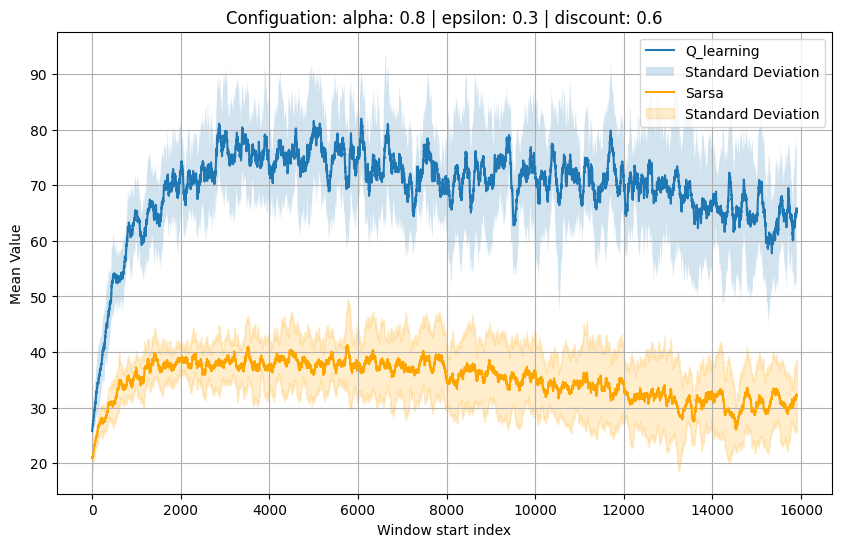

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


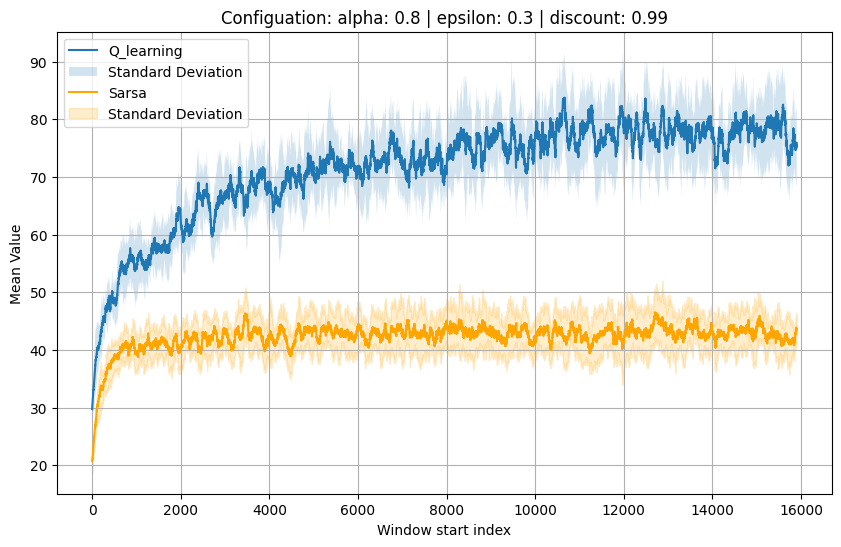

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


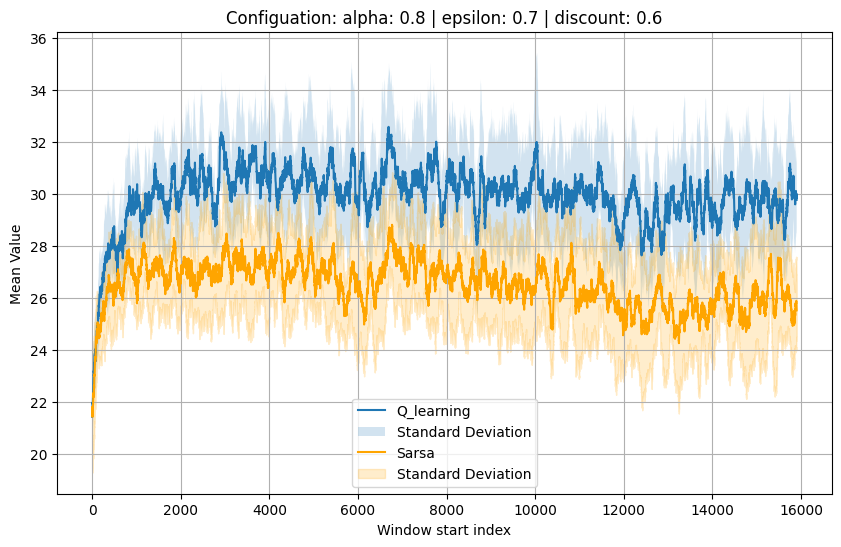

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


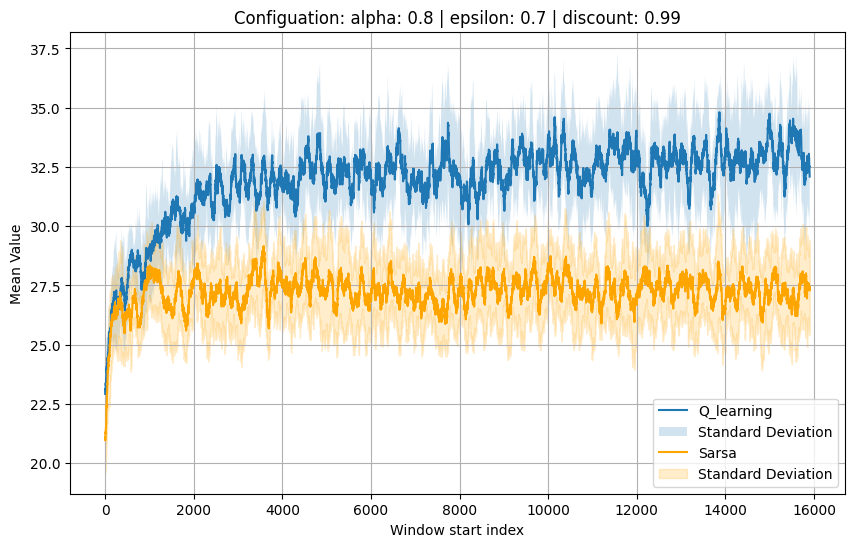

In [60]:
for alpha, epsilon, discount in itertools.product(alphas, epsilons, discounts):
    config = QLearningConfig(
    environment_name='CartPole-v1',
    buckets_sizes=discretization,
    discount_factor=discount,
    experiment_rate_max=epsilon,
    learning_rate_max=alpha,
    upper_bounds=upper_bounds,
    lower_bounds=lower_bounds
    )

    learner_q = QLearner(config)
    learner_s = QLearner(config)
    arrays_q = []
    arrays_s = []

    for i in range(10):
        learner_s.reset()
        learner_q.reset()
        arrays_s.append(learner_s.learn(16000, tactic=LearningTactic.SARSA))
        arrays_q.append(learner_q.learn(16000, tactic=LearningTactic.QLEARNING))

    window_size = 100

    means_across_arrays_q = []
    std_devs_across_arrays_q = []
    means_across_arrays_s = []
    std_devs_across_arrays_s = []

    for i in range(16000 - window_size + 1):
        window_means_q = []
        window_means_s = []
        
        for array in arrays_q:
            window_q = array[i:i + window_size]
            window_means_q.append(np.mean(window_q))
        
        means_across_arrays_q.append(np.mean(window_means_q))
        std_devs_across_arrays_q.append(np.std(window_means_q))

        for array in arrays_s:
            window_s = array[i:i + window_size]
            window_means_s.append(np.mean(window_s))
        
        means_across_arrays_s.append(np.mean(window_means_s))
        std_devs_across_arrays_s.append(np.std(window_means_s))

    x_q = np.arange(len(means_across_arrays_q))
    x_s = np.arange(len(means_across_arrays_s))

    plt.figure(figsize=(10, 6))
    plt.plot(x_q, means_across_arrays_q, label='Q_learning')

    plt.fill_between(x_q, np.array(means_across_arrays_q) - np.array(std_devs_across_arrays_q), 
                    np.array(means_across_arrays_q) + np.array(std_devs_across_arrays_q), alpha=0.2, label='Standard Deviation')

    plt.plot(x_s, means_across_arrays_s, label='Sarsa', color='orange')

    plt.fill_between(x_s, np.array(means_across_arrays_s) - np.array(std_devs_across_arrays_s), 
                    np.array(means_across_arrays_s) + np.array(std_devs_across_arrays_s), alpha=0.2, color='orange', label='Standard Deviation')

    plt.title(f"Configuation: alpha: {alpha} | epsilon: {epsilon} | discount: {discount}")
    plt.xlabel("Window start index")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)

    plt.show()

## Wnioski
Większy discount_rate jest uniwersalnie lepszy, co jest sensowne dla tego konkretnego problemu.

Duży experiment_rate przez cały czas treningu, nie poprawia wyników w późniejszych okresach uczenia, bo model nie może uczyć się na własnej wiedzy (eksploatować). Epsilon powinien być albo mały cały czas, albo duży na początku i maleć zgodnie z jakimś wzorem/strategią.

Sarsa jest w większości przypadków gorsza, z wyjątkiem dwóch, gdzie jest bardzo porównywalna. W tych dwóch przypadkach mamy małe stałe uczące, co sugeruje, że sarsa działa lepiej przy małych wartościach alpha.

Najlepszą konfiguracją okazała się ta z małymi experiment_rate i learning_rate oraz wysoką stałą uczącą. Wykonujemy wystarczająco eksperymentów, żeby coś się uczyć i dużo eksploatujemy. Mała stała ucząca zapewnia z kolei stabilność - wykres charakteryzuje się stosunkowo małym odhyleniem standardowym zarówno dla sarsy i q-learningu.

In [61]:
config = QLearningConfig(
environment_name='CartPole-v1',
buckets_sizes=discretization,
discount_factor=0.99,
experiment_rate_max=0.3,
learning_rate_max=0.2,
upper_bounds=upper_bounds,
lower_bounds=lower_bounds
)

learner = QLearner(config)
x = learner.learn(16000, print_stats=True, tactic=LearningTactic.QLEARNING, print_every=1000)

d:\anaconda3\envs\myenv\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode    1000     | Average from last 1000:   42.77     | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    1.40   
Episode    2000     | Average from last 1000:   90.84     | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    2.82   
Episode    3000     | Average from last 1000:   96.77     | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    2.92   
Episode    4000     | Average from last 1000:   98.62     | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    2.91   
Episode    5000     | Average from last 1000:   102.99    | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    2.55   
Episode    6000     | Average from last 1000:   104.59    | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    2.93   
Episode    7000     | Average from last 1000:   108.08    | Alpha:    0.20     | Epsilon:    0.30    | Time elapsed:    3.56   
Episo

In [62]:
learner.test(1000)

313.466

Powyżej mamy śednią nagrodę ze 1000 symulacji, w których model korzysta tylko ze zgromadzonej wiedzy. To dobry wynik, ale wciąż daleki od rozwiązania problemu - 500.

# Eksperyment z zanikającymi parametrami - Q-learning i Sarsa
Idea jest prosta - parametry alpha i epsilon zmierzając od maximum do minimum z określoną prędkością (decay) wg wzoru: min + (max - min) * e^(decay * episode).


Zapewnia to stosunkowo krótki okres skupiony na eksploracji, gdzie model dużo się uczy, potem okres zrównoważonej eksploracji i eksploatacji, gdzie model powinien osiągnąć maximum i nak końcu okres skupiony wyłącznie na eksploatacji, gdzie model stabilizuje się na stosunkowo małej stałej uczącej. W procesie uczenia wypisuje co 1000 epizodów wartości stłych jak również średni wynik z ostatnich 1000 epizodów.

In [54]:
config_1 = QLearningConfig(
    environment_name='CartPole-v1',
    buckets_sizes=discretization,
    discount_factor=0.999,
    experiment_rate_max=0.9,
    experiment_rate_min=0.01,
    experiment_rate_decay=3.0e-4,
    learning_rate_max=0.6,
    learning_rate_min=0.025,
    learning_rate_decay=3.0e-4,
    upper_bounds=upper_bounds,
    lower_bounds=lower_bounds
)

config_2 = QLearningConfig(
    environment_name='CartPole-v1',
    buckets_sizes=discretization,
    discount_factor=0.999,
    experiment_rate_max=0.6,
    experiment_rate_min=0.01,
    experiment_rate_decay=3.6e-4,
    learning_rate_max=0.4,
    learning_rate_min=0.01,
    learning_rate_decay=3.4e-4,
    upper_bounds=upper_bounds,
    lower_bounds=lower_bounds
)

In [55]:
learner = QLearner(config_1)
learner.print_parameters()
x = learner.learn(16000, print_stats=True, tactic=LearningTactic.QLEARNING, print_every=1000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Initial Parameters:
Buckets:    [[0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25], [0.35, 0.15, 0.15, 0.35], [0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25], [0.3, 0.15, 0.05, 0.05, 0.15, 0.3]]
Lower bounds:    [-4.8, -0.5, -0.418, -0.8726646259971648]
Upper bounds:    [4.8, 0.5, 0.418, 0.8726646259971648]
Learning rate (alpha) max:   0.6
Learning rate (alpha) min:   0.025
Learning rate (alpha) decay: 0.0003
Exploration rate (epsilon) max:   0.9
Exploration rate (epsilon) min:   0.01
Exploration rate (epsilon) decay: 0.0003
Discount factor (gamma): 0.999
Episode    1000     | Average from last 1000:   26.75     | Alpha:    0.45     | Epsilon:    0.67    | Time elapsed:    0.62   
Episode    2000     | Average from last 1000:   39.98     | Alpha:    0.34     | Epsilon:    0.50    | Time elapsed:    0.84   
Episode    3000     | Average from last 1000:   61.88     | Alpha:    0.26     | Epsilon:    0.

In [42]:
learner_sarsa = QLearner(config_2)
learner_sarsa.print_parameters()
x = learner_sarsa.learn(16000, tactic=LearningTactic.SARSA, print_stats=True, print_every=1000)

d:\anaconda3\envs\myenv\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Initial Parameters:
Buckets:    [[0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25], [0.35, 0.15, 0.15, 0.35], [0.25, 0.125, 0.1, 0.05, 0.1, 0.125, 0.25], [0.3, 0.15, 0.05, 0.05, 0.15, 0.3]]
Lower bounds:    [-4.8, -0.5, -0.418, -0.8726646259971648]
Upper bounds:    [4.8, 0.5, 0.418, 0.8726646259971648]
Learning rate (alpha) max:   0.4
Learning rate (alpha) min:   0.01
Learning rate (alpha) decay: 0.00034
Exploration rate (epsilon) max:   0.6
Exploration rate (epsilon) min:   0.01
Exploration rate (epsilon) decay: 0.00036
Discount factor (gamma): 0.999
Episode    1000     | Average from last 1000:   37.16     | Alpha:    0.29     | Epsilon:    0.42    | Time elapsed:    0.74   
Episode    2000     | Average from last 1000:   63.01     | Alpha:    0.21     | Epsilon:    0.30    | Time elapsed:    1.23   
Episode    3000     | Average from last 1000:   103.87    | Alpha:    0.15     | Epsilon:    0

d:\anaconda3\envs\myenv\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


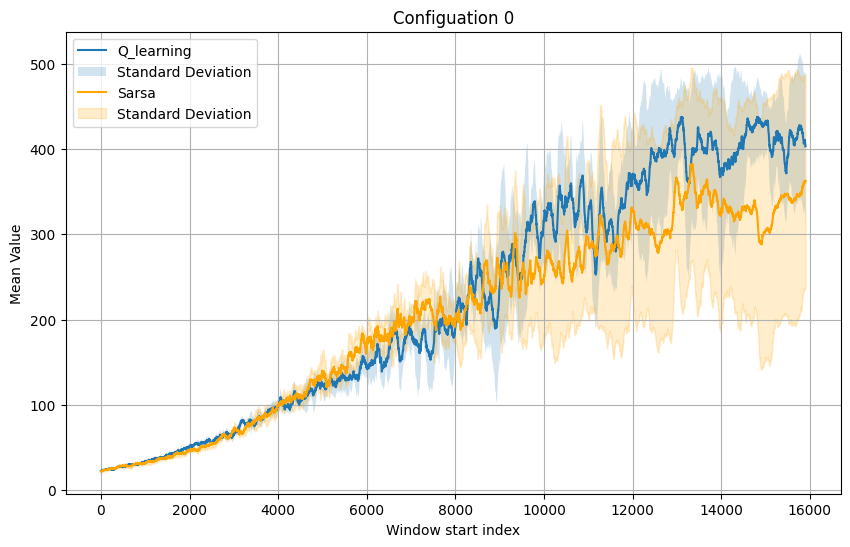

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


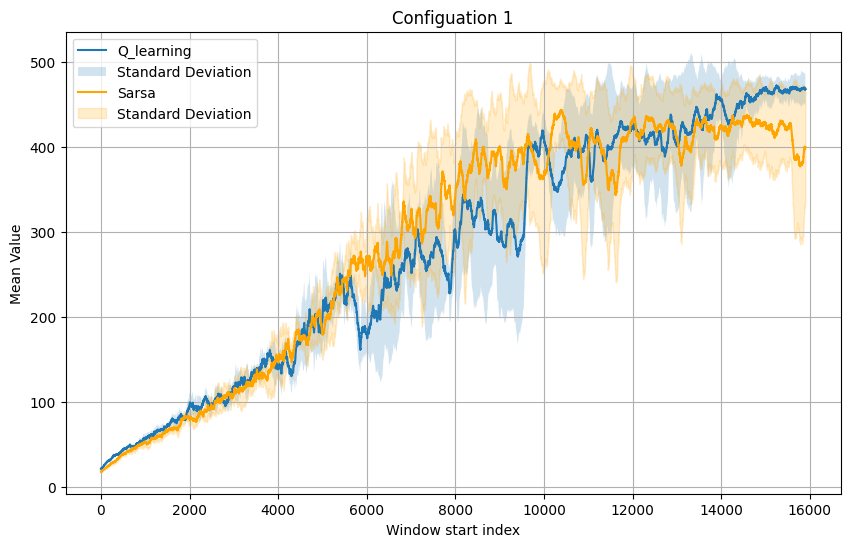

In [58]:
for index, config in enumerate([config_1, config_2]):
    learner_q = QLearner(config)
    learner_s = QLearner(config)
    arrays_q = []
    arrays_s = []

    for i in range(5):
        learner_s.reset()
        learner_q.reset()
        arrays_s.append(learner_s.learn(16000, tactic=LearningTactic.SARSA))
        arrays_q.append(learner_q.learn(16000, tactic=LearningTactic.QLEARNING))

    window_size = 100

    means_across_arrays_q = []
    std_devs_across_arrays_q = []
    means_across_arrays_s = []
    std_devs_across_arrays_s = []

    for i in range(16000 - window_size + 1):
        window_means_q = []
        window_means_s = []
        
        for array in arrays_q:
            window_q = array[i:i + window_size]
            window_means_q.append(np.mean(window_q))
        
        means_across_arrays_q.append(np.mean(window_means_q))
        std_devs_across_arrays_q.append(np.std(window_means_q))

        for array in arrays_s:
            window_s = array[i:i + window_size]
            window_means_s.append(np.mean(window_s))
        
        means_across_arrays_s.append(np.mean(window_means_s))
        std_devs_across_arrays_s.append(np.std(window_means_s))

    x_q = np.arange(len(means_across_arrays_q))
    x_s = np.arange(len(means_across_arrays_s))

    plt.figure(figsize=(10, 6))
    plt.plot(x_q, means_across_arrays_q, label='Q_learning')

    plt.fill_between(x_q, np.array(means_across_arrays_q) - np.array(std_devs_across_arrays_q), 
                    np.array(means_across_arrays_q) + np.array(std_devs_across_arrays_q), alpha=0.2, label='Standard Deviation')

    plt.plot(x_s, means_across_arrays_s, label='Sarsa', color='orange')

    plt.fill_between(x_s, np.array(means_across_arrays_s) - np.array(std_devs_across_arrays_s), 
                    np.array(means_across_arrays_s) + np.array(std_devs_across_arrays_s), alpha=0.2, color='orange', label='Standard Deviation')

    plt.title(f"Configuation {index}")
    plt.xlabel("Window start index")
    plt.ylabel("Mean Value")
    plt.legend()
    plt.grid(True)

    plt.show()

Z tych dwóch konfiguracji można wywnioskować, że sarsa szybciej zbiega do optymalnego rozwiązania w trakcie uczenia, jednak q-learning okazuje się lepszy przy wiekszej ilości epizodów. Możemy też zauważyć, że sarsa jest mniej stabilna - większe odhylenie standardowe. Sarsa też zdaje lepiej sobie dawać radę, gdy zainicjalizowano mniejsze experiment_rate i learning_rate a oba podejścia są wtedy dużo bardziej stabilne. Proces uczenia przypomina ruchy na giełdzie tj. rządzą się swoimi prawami i średnio wiadomo o co chodzi, ale przynajmniej akcje idą w górę.

Jest to chyba sprzeczne z intuicją, że q-learning powinien się uczyć szybciej (zakłada, że następna akcja jest tą lokalnie optymalną) i, że sarsa jest bardziej stabilna (nie ma sytuacji, że założyliśmy, że podjeliśmy akcje a, żeby potem wylosować inną). Prawdopodobnie jest to kwestia środowiska.

W każdym razie, w obu wariantach uzystkujemy bardzo dobre wyniki - przy szcześliwym treningu nawet perfekcyjny wynik - 500.